In [672]:
import numpy as np
import pandas as pd
import os, sys
from astropy import units as u
import random
import h5py
import itertools
import pickle
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='w')
rc('xtick', labelsize=20)
rc('ytick', labelsize=20)

from dtaidistance import dtw, clustering
from dtaidistance import dtw_visualisation as dtwvis

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage

sys.path.append('/astro/users/jbirky/projects/tess_binaries')
os.environ['TESS_DATA'] = '/data/epyc/projects2/tess'

import tess_binaries as tb

Possible improvements:
- will adding periods improve hierarchical classification?
- way to visualize distances between all objects - euclidean graph?

In [633]:
ff = h5py.File(f'{tb.cat_dir}/asassn_tess_inspected.hdf5', mode="r")

df = {}
for key in list(ff):
    if key == 'type':
        df[key] = np.array(ff[key].value, dtype='str')
    else:
        df[key] = ff[key].value
    
ff.close()
sample = pd.DataFrame(data=df)
print(len(sample))

1004


/epyc/opt/anaconda/lib/python3.6/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [673]:
ls_period, bls_period = [], []
for ID in list(sample['tic_id']):
    infile = open(f'{tb.ps_dir}/{ID}_ps.pkl','rb')
    ps_dict = pickle.load(infile)
    infile.close()
    ls_period.append(ps_dict['ls_best_period'])
    bls_period.append(ps_dict['bls_best_period'])
sample['ls_period'] = np.array(ls_period)
sample['bls_period'] = np.array(bls_period)

In [674]:
# sample['type'].value_counts().plot(kind='bar', figsize=[18,6])

In [675]:
# for typ in ['EA', 'EB', 'EW']:
#     sample[sample['type'] == typ]['period'].plot(kind='hist', bins=np.linspace(0,25,100), facecolor='none', histtype='step', figsize=[18,6], label=typ, logy=True).legend(loc='upper right')

In [676]:
# for typ in ['ROT', 'HADS', 'DCEP', 'RRAB', 'RRC']:
#     sample[sample['type'] == typ]['period'].plot(kind='hist', bins=np.linspace(0,25,100), facecolor='none', histtype='step', figsize=[18,6], label=typ, logy=True).legend(loc='upper right')

In [666]:
# N = 20
# demo = np.random.choice(len(sample), N, replace=False)

N = len(sample)
demo = np.arange(0,N)
subsamp = sample.loc[demo]
subsamp = subsamp.reset_index(drop=True)

In [668]:
#Group types into more general classes

new_label = []

for typ in subsamp['type']:
    if typ in ['EA', 'EB', 'EW','RRAB', 'RRC', 'HADS', 'DCEP', 'ROT']:
        new_label.append(typ)
    elif typ in ['DSCT', 'DSCT:']:
        new_label.append('DSCT')
    elif typ in ['DCEP', 'DECPS']:
        new_label.append('DCEP')
    else:
        new_label.append('MISC')

# for typ in subsamp['type']:
#     if typ in ['EA', 'EB', 'EW']:
#         new_label.append('BINARIES')
#     else:
#         new_label.append('GARBAGE')

# for typ in subsamp['type']:
#     if typ in ['EA']:
#         new_label.append('EA')
#     elif typ in ['EB']:
#         new_label.append('EB')
#     elif typ in ['EW']:
#         new_label.append('EW')
#     else:
#         new_label.append('GARBAGE')
        
subsamp = subsamp.assign(label=subsamp['type'], type=new_label)

In [658]:
model = clustering.LinkageTree(dtw.distance_matrix_fast, {})
cluster_idx = model.fit(list(subsamp['flux']))

In [659]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, N/2))
model.plot("clustering.png", axes=ax, show_ts_label=list(subsamp['type']),
           show_tr_label=True, ts_label_margin=0,
           ts_left_margin=0, ts_sample_length=1)

(None, None)

In [661]:
ds = dtw.distance_matrix_fast(list(subsamp['flux']), window=20)
ds[ds == np.inf] = 0
dmatrix = ds + ds.T

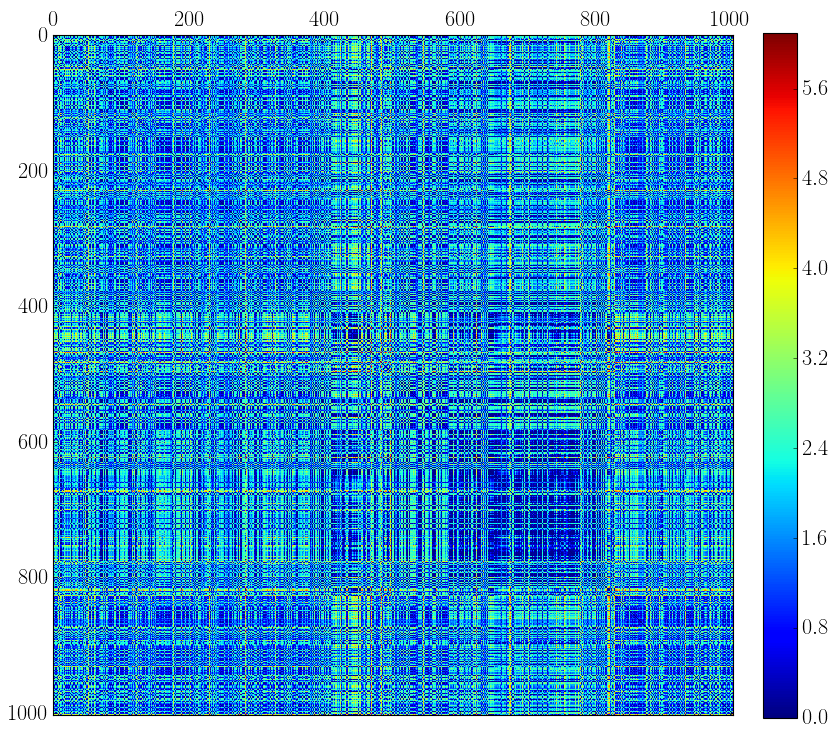

In [662]:
plt.figure(figsize=(12,12))
im = plt.matshow(dmatrix, fignum=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.savefig('matrix.png')
plt.show()

In [642]:
def plotConfusionMatrix(cmatrix, tnames, **kwargs):
    
    k = kwargs.get('k', 'k')
    show_percent = kwargs.get('percent', False)
    nlabel = len(tnames)

    fig, ax = plt.subplots(figsize=[12,12])
    if show_percent == True:
        cmatrix = np.round(cmatrix/np.sum(cmatrix, axis=0), 2)
    
    im = ax.matshow(cmatrix, cmap='Blues', norm=colors.PowerNorm(gamma=0.6))

    ax.set_xticks(np.arange(nlabel))
    ax.set_yticks(np.arange(nlabel))
    ax.set_xticklabels(tnames)
    ax.set_yticklabels(tnames)

    ax.xaxis.set_ticks_position('bottom')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(nlabel):
        for j in range(nlabel):
            val = cmatrix[i, j]
            if val > .65*(np.max(cmatrix) - np.min(cmatrix)):
                text = ax.text(j, i, val, ha="center", va="center", color="w")
            else:
                text = ax.text(j, i, val, ha="center", va="center", color="k")

    ax.set_title(f"{k}-NN Confusion Matrix", fontsize=25)
    ax.set_xlabel('Reference Label', fontsize=20)
    ax.set_ylabel(f'{k}-NN Label', fontsize=20)
    fig.tight_layout()
    if 'save_dir' in kwargs:
        plt.savefig(kwargs.get('save_dir'))
    
    return fig

def returnKNN(dmatrix, k):
    
    nn1 = []
    for i in range(len(dmatrix)):
        min_dist = sorted(dmatrix[i])[1:k+1]
        min_dist_ind = np.array([np.where(dmatrix[i] == d)[0][0] for d in min_dist])
        votes = np.array(subsamp['type'])[min_dist_ind]
        best = Counter(votes).most_common(1)[0][0]
        nn1.append(best)

    train = list(subsamp['type'])
    test = nn1
    
    return confusion_matrix(test, train, labels=tnames)

In [645]:
for k in range(1,10):
    cmatrix = returnKNN(dmatrix, k)
    print(f'{k}-NN overall accuracy:', round(np.sum(np.diagonal(cmatrix))/np.sum(cmatrix), 2))

1-NN overall accuracy: 0.78
2-NN overall accuracy: 0.78
3-NN overall accuracy: 0.81
4-NN overall accuracy: 0.83
5-NN overall accuracy: 0.82
6-NN overall accuracy: 0.84
7-NN overall accuracy: 0.82
8-NN overall accuracy: 0.84
9-NN overall accuracy: 0.82


1-NN overall accuracy: 0.78


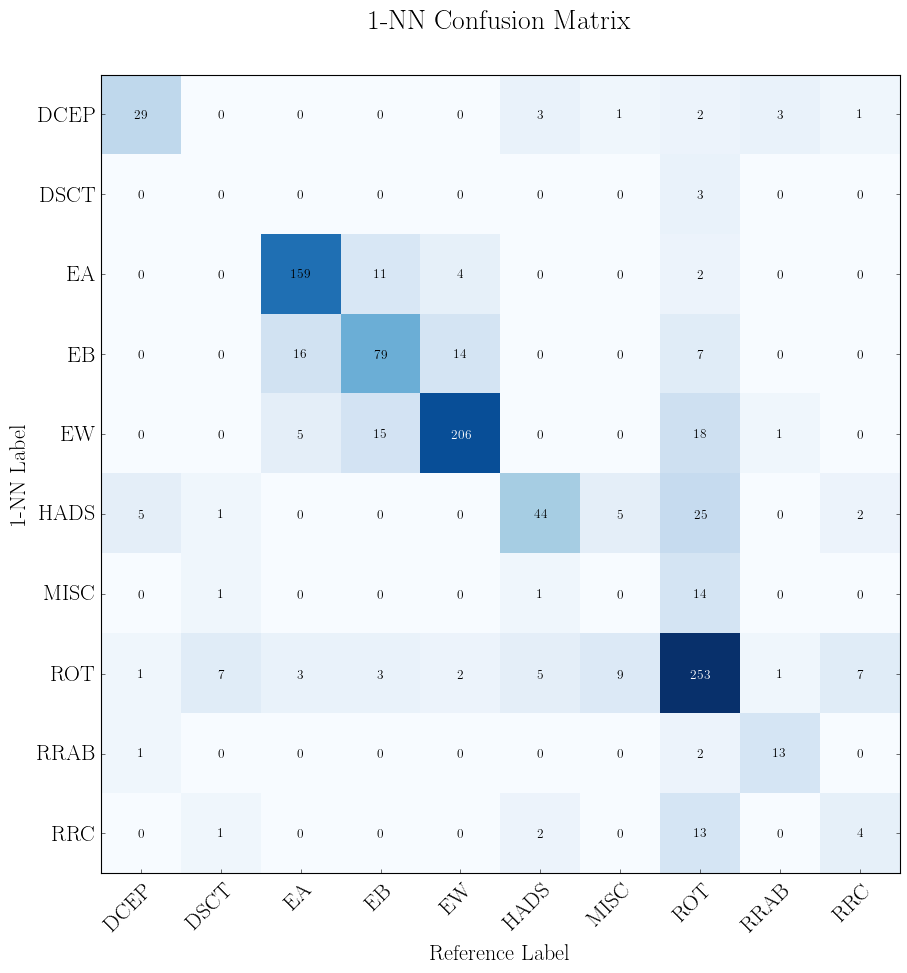

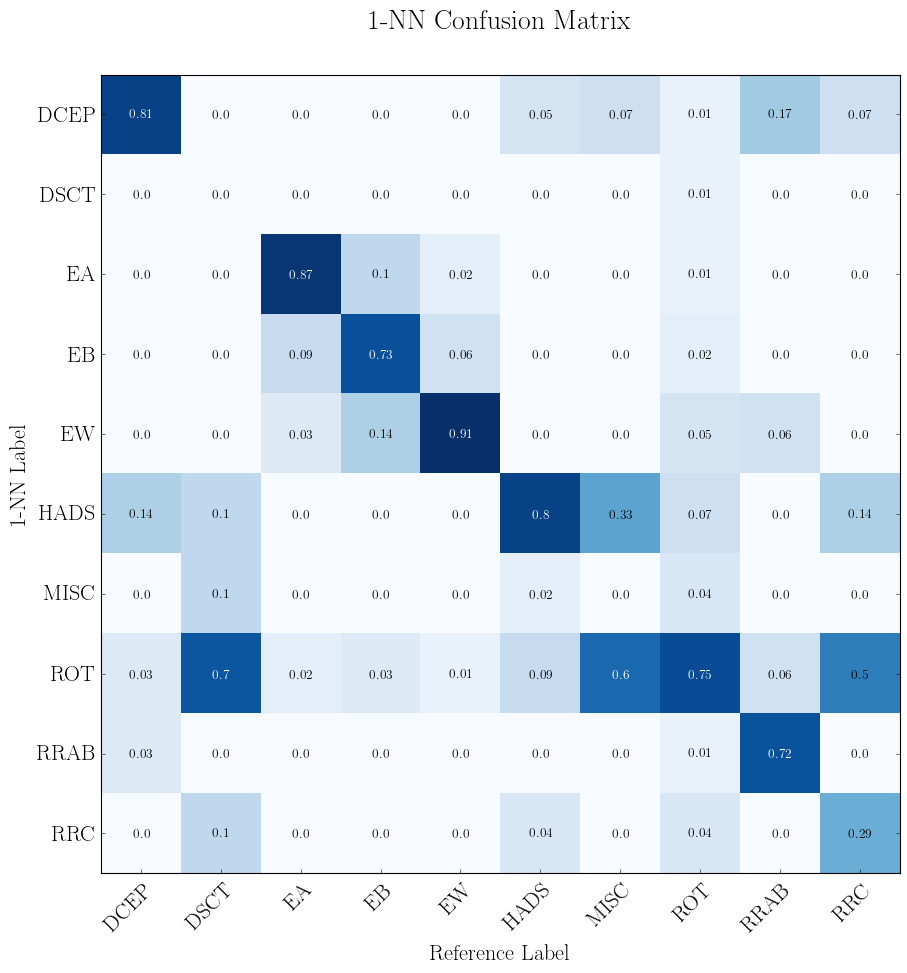

In [669]:
k = 1
tnames = np.array(sorted(list(set(subsamp['type']))))

cmatrix = returnKNN(dmatrix, k)
print(f'{k}-NN overall accuracy:', round(np.sum(np.diagonal(cmatrix))/np.sum(cmatrix), 2))

plot = plotConfusionMatrix(cmatrix, tnames, k=k, percent=False, save_dir=f'{k}NN_confusion.png')
plot = plotConfusionMatrix(cmatrix, tnames, k=k, percent=True, save_dir=f'{k}NN_confusion.png')